Dataset folder: /content/dataset/ProcessedDataSet
Example files: ['7', '6', '3', '4', '2', '1', '9', '8', '0', '5']
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Total images: 50
Using device: cpu
Epoch 1/8 - Train Loss: 2.5549, Val Loss: 2.3895
Epoch 2/8 - Train Loss: 2.3155, Val Loss: 2.4008
Epoch 3/8 - Train Loss: 2.2084, Val Loss: 2.5699
Epoch 4/8 - Train Loss: 2.1509, Val Loss: 2.8893
Epoch 5/8 - Train Loss: 1.8470, Val Loss: 3.2552
Epoch 6/8 - Train Loss: 1.4687, Val Loss: 4.5722
Epoch 7/8 - Train Loss: 0.9947, Val Loss: 4.9261
Epoch 8/8 - Train Loss: 0.6124, Val Loss: 6.5220


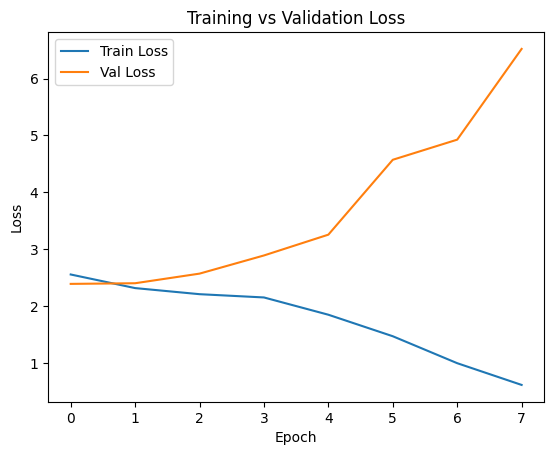

Model saved to: /content/puzzarm_model.pth


In [25]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

data_dir = "/content/dataset/ProcessedDataSet"   # <- key change
print("Dataset folder:", data_dir)
print("Example files:", os.listdir(data_dir)[:10])

# --- transforms and dataset ---
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),    # ensure 3 channels
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

full_dataset = datasets.ImageFolder(data_dir, transform=transform)

train_size = int(0.7 * len(full_dataset))
val_size   = int(0.2 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # makes split repeatable
)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=4, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=4, shuffle=False)

class_names = full_dataset.classes
print("Classes:", class_names)
print("Total images:", len(full_dataset))

# --- model ---
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 64),  # 128 -> 64 -> 32 so this is correct
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SimpleCNN(num_classes=len(class_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 8
train_losses = []
val_losses   = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}")

# --- plot losses ---
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# --- save model ---
save_path = "/content/puzzarm_model.pth"
torch.save(model.state_dict(), save_path)
print("Model saved to:", save_path)


In [26]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 128x128 -> 64x64

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)    # 64x64 -> 32x32
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 64),  # 32 channels * 32 * 32
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SimpleCNN(num_classes=len(class_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 8
train_losses = []
val_losses   = []

for epoch in range(epochs):
    # ---- TRAIN ----
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # ---- VALIDATION ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    epoch_val_loss = val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}")


Using device: cpu
Epoch 1/8 - Train Loss: 2.4568, Val Loss: 2.3310
Epoch 2/8 - Train Loss: 2.2931, Val Loss: 2.3177
Epoch 3/8 - Train Loss: 2.2487, Val Loss: 2.4694
Epoch 4/8 - Train Loss: 2.1164, Val Loss: 3.0789
Epoch 5/8 - Train Loss: 1.8082, Val Loss: 4.2955
Epoch 6/8 - Train Loss: 1.2821, Val Loss: 5.1541
Epoch 7/8 - Train Loss: 0.8651, Val Loss: 7.2265
Epoch 8/8 - Train Loss: 0.4186, Val Loss: 8.9523


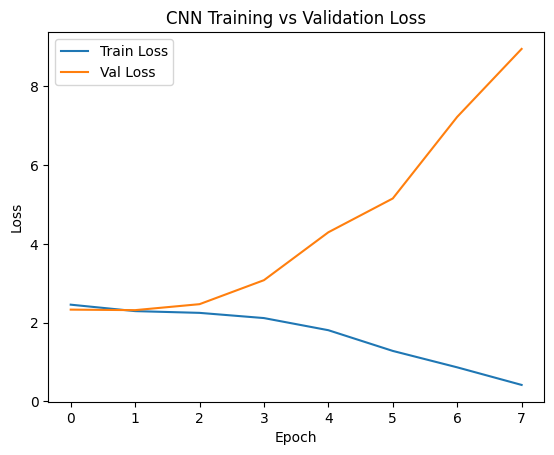

In [28]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("CNN Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [29]:
# --- test accuracy ---
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

test_acc = correct / total if total > 0 else 0.0
print(f"CNN Test Accuracy: {test_acc:.3f}")

# --- save model ---
save_path = "/content/puzzarm_cnn_model.pth"
torch.save(model.state_dict(), save_path)
print("CNN model saved to:", save_path)


CNN Test Accuracy: 0.000
CNN model saved to: /content/puzzarm_cnn_model.pth


In [30]:
model.eval()
print("Number of batches in test_loader:", len(test_loader))

for batch_idx, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    print(f"Batch {batch_idx}")
    print("True labels:", labels.cpu().numpy())
    print("Pred labels:", preds.cpu().numpy())


Number of batches in test_loader: 2
Batch 0
True labels: [4 9 5 8]
Pred labels: [1 8 7 5]
Batch 1
True labels: [1]
Pred labels: [3]


In [31]:
from torchvision import models
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


In [33]:
num_classes = len(class_names)

mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# Replace final layer with our number of classes
in_features = mobilenet.classifier[1].in_features
mobilenet.classifier[1] = nn.Linear(in_features, num_classes)

mobilenet = mobilenet.to(device)

criterion_m = nn.CrossEntropyLoss()
optimizer_m = optim.Adam(mobilenet.parameters(), lr=1e-4)

epochs_m = 8
train_losses_m = []
val_losses_m   = []

for epoch in range(epochs_m):
    mobilenet.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer_m.zero_grad()
        outputs = mobilenet(images)
        loss = criterion_m(outputs, labels)
        loss.backward()
        optimizer_m.step()

        running_loss += loss.item()

    train_losses_m.append(running_loss / len(train_loader))

    # validation
    mobilenet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mobilenet(images)
            loss = criterion_m(outputs, labels)
            val_loss += loss.item()

    val_losses_m.append(val_loss / len(val_loader))

    print(f"[MobileNet] Epoch {epoch+1}/{epochs_m} - "
          f"Train Loss: {train_losses_m[-1]:.4f}, "
          f"Val Loss: {val_losses_m[-1]:.4f}")



[MobileNet] Epoch 1/8 - Train Loss: 2.3631, Val Loss: 2.3404
[MobileNet] Epoch 2/8 - Train Loss: 2.1883, Val Loss: 2.2721
[MobileNet] Epoch 3/8 - Train Loss: 2.1212, Val Loss: 2.2783
[MobileNet] Epoch 4/8 - Train Loss: 2.0386, Val Loss: 2.3193
[MobileNet] Epoch 5/8 - Train Loss: 1.9688, Val Loss: 2.3078
[MobileNet] Epoch 6/8 - Train Loss: 1.8530, Val Loss: 2.3568
[MobileNet] Epoch 7/8 - Train Loss: 1.7582, Val Loss: 2.3001
[MobileNet] Epoch 8/8 - Train Loss: 1.6411, Val Loss: 2.2804


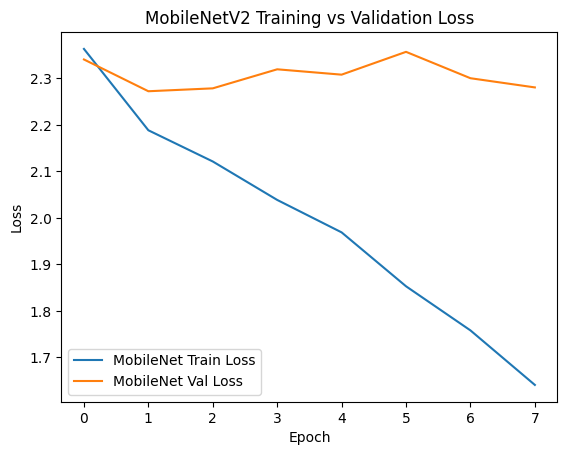

In [34]:
plt.plot(train_losses_m, label="MobileNet Train Loss")
plt.plot(val_losses_m, label="MobileNet Val Loss")
plt.title("MobileNetV2 Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [37]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def evaluate_model(model, loader, class_names, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    acc = (all_labels == all_preds).mean()
    print("Accuracy:", acc)
    print(classification_report(all_labels, all_preds,
                                target_names=class_names,
                                digits=3))

    cm = confusion_matrix(all_labels, all_preds)
    return acc, cm


In [38]:
print("=== CNN on test set ===")
acc_cnn, cm_cnn = evaluate_model(model, test_loader, class_names, device)

print("\n=== MobileNetV2 on test set ===")
acc_mnet, cm_mnet = evaluate_model(mobilenet, test_loader, class_names, device)

print("\nCNN test accuracy:", acc_cnn)
print("MobileNetV2 test accuracy:", acc_mnet)


=== CNN on test set ===
Accuracy: 0.0


ValueError: Number of classes, 7, does not match size of target_names, 10. Try specifying the labels parameter